In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_classif
import copy
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import statistics
import plotly.graph_objs as go
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import Dense
from keras._tf_keras.keras.optimizers import Adam
from keras._tf_keras.keras.losses import BinaryCrossentropy
from keras._tf_keras.keras import backend as K
import numpy as np
import tensorflow as tf
from keras._tf_keras.keras.optimizers import SGD, Adam
import random

In [18]:
class CustomMLPClassifier:
    def __init__(self, hidden_layer_size = 100, max_iter=100, random_state=None, input_dim = 23):
        if random_state:
            tf.random.set_seed(random_state)
            np.random.seed(random_state)
            random.seed(random_state)
        self.model = Sequential([
            Dense(hidden_layer_size, activation='relu', input_dim=input_dim),
            Dense(95, activation='relu'),
            Dense(95, activation='relu'),
            Dense(95, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        max_iter = 20
        self.max_iter = max_iter
        self.random_state = random_state

    def compile_model(self):
        optimizer=Adam(learning_rate=0.0002)
        loss='binary_crossentropy'
        self.model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    def fit(self, X_train, y_train, **kwargs):
        X_train = X_train.values
        y_train = y_train.values
        self.model.fit(X_train, y_train, epochs=self.max_iter, batch_size=32, verbose=1, initial_epoch=1, validation_split=0.1, shuffle=False, **kwargs)

    def predict(self, X_test):
        dta = self.model.predict(X_test)
        arr_list = dta.flatten().tolist()
        arr_list_int = [int(x) for x in arr_list]
        return arr_list_int

In [9]:
class DataAnalyzer:
    def __init__(self, with_smote = True, algo = "knn"):
        file_path = 'default of credit card clients.csv'

        self.dataset = pd.read_csv(file_path, header=None)
        self.dataset.columns = self.dataset.iloc[1]

        self.dataset = self.dataset.drop([0, 1])
        self.dataset = self.dataset.drop(self.dataset.columns[0], axis=1)
        # Reset the index
        self.dataset = self.dataset.reset_index(drop=True)
        self.original_dataset = self.dataset
        self.convert_columns()
        self.with_smote = with_smote
        self.algo = algo
    
    def convert_columns(self):
        # Convert all columns to float except 'default payment next month' and 'Net Income Flag'
        for column in self.dataset.columns:
            if column not in ["ID", "SEX", "EDUCATION", "MARRIAGE", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6", "default payment next month"]:
                self.dataset[column] = self.dataset[column].astype(float)
            else:
                self.dataset[column] = self.dataset[column].astype(int)

    def show_class_distribution(self):
        target_column = 'default payment next month'
        # Load your dataset into a pandas DataFrame

        # Step 2: Inspect the Target Variable
        class_distribution = self.dataset[target_column].value_counts()

        # Step 3: Visualize the Distribution
        class_distribution.plot(kind='bar', title='Target Variable Distribution')
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.show()

    def show_heat_map(self, dataset = None):
        if dataset is None:
            corr_matrix = self.dataset.corr()
        else:
            corr_matrix = dataset.corr()
        plt.figure(figsize=(20, 20))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title("Correlation Matrix")
        plt.show()

    def get_x_and_Y(self):
        self.X = self.dataset.drop('default payment next month', axis=1)  # Assuming 'p' is the target variable
        self.y = self.dataset['default payment next month']
        return (self.X, self.y)
    
    def perform_manual_splitting_without_cv(self):
        smote = SMOTE(random_state=42)
        X_train, self.X_test_final, y_train, self.y_test_final = train_test_split(self.X, self.y, test_size=0.2, random_state=0)
        if self.with_smote:
            self.X_train, self.y_train = smote.fit_resample(X_train, y_train)
        else:
            self.X_train, self.y_train = X_train, y_train
    
    def perform_manual_splitting_cv(self):
        # First split to get training set and first test set
        smote = SMOTE(random_state=42)
        X_train, X_temp, y_train, y_temp = train_test_split(self.X, self.y, test_size=0.4, random_state=0)
        if self.with_smote:
            self.X_train, self.y_train = smote.fit_resample(X_train, y_train)
        else:
            self.X_train, self.y_train = X_train, y_train
        self.X_cv, self.X_test_final, self.y_cv, self.y_test_final = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)
    
    def perform_kfold_cv(self, num_of_columns = None):
        X_train, X_test_final, y_train, y_test_final = train_test_split(self.X, self.y, test_size=0.2, random_state=0)
        if num_of_columns:
            X_train = copy.deepcopy(X_train.iloc[:, :num_of_columns])
            X_test_final = copy.deepcopy(X_test_final.iloc[:, :num_of_columns])
        self.X_train = X_train
        self.y_train = y_train.astype(int)
        self.X_test_final = X_test_final.reindex(X_train.columns, axis=1)
        self.y_test_final = y_test_final.astype(int)
        if self.algo == "knn":
            classifier = KNeighborsClassifier(n_neighbors = 40, metric = 'minkowski', p = 2.7)
        elif self.algo == "rf":
            classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        elif self.algo == "svm":
            classifier = SVC(kernel='rbf', random_state=42)
        elif self.algo == "logreg":
            classifier = LogisticRegression(random_state=42)
        elif self.algo == "nn":
            custom_mlp = CustomMLPClassifier(max_iter=100, random_state=42)
            custom_mlp.compile_model()  # You may need to pass additional parameters here depending on your requirements
            classifier = custom_mlp 

        # Perform k-fold cross-validation
        kf = KFold(n_splits=5, shuffle=True, random_state=0)

        scores = []
        best_model = None
        best_avg_score = 0.0 

        for train_index, val_index in kf.split(X_train):
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index].astype(int), y_train.iloc[val_index].astype(int)

            # Train the model on the training fold
            smote = SMOTE(random_state=42)
            if self.with_smote:
                X_train_smote, y_train_smote = smote.fit_resample(X_train_fold, y_train_fold)
            else:
                X_train_smote, y_train_smote = X_train_fold, y_train_fold
            classifier.fit(X_train_smote, y_train_smote)

            # Evaluate the model on the validation fold
            y_val_pred = classifier.predict(X_val_fold)
            score = accuracy_score(y_val_fold, y_val_pred)

            # Update the best model if the current model has a better average performance
            if score > best_avg_score:
                best_avg_score = score
                best_model = classifier
            scores.append(score)
        
        self.classifier = best_model
        return(best_avg_score, scores)
    
    def perform_filter_methods(self):
        data = copy.deepcopy(self.dataset)
        X = copy.deepcopy(data).drop(columns=['default payment next month'])  # Features
        print("total features = ", len(X.columns))
        y = copy.deepcopy(data['default payment next month']).astype(int) 
        # Calculate Mutual Information scores
        mi_scores = mutual_info_classif(X, y)
        # Select features with MI score > 0.5
        selected_features = X.columns[mi_scores > 0.01]
        print("selected features with high mutual information with the target = ", len(selected_features))
        # Calculate correlation matrix
        corr_matrix = X[selected_features].corr().abs()
        copy_ds = copy.deepcopy(data[selected_features])
        # Remove one of two highly correlated features
        to_drop = set()
        dropped_columns = {}
        for i in range(len(corr_matrix.columns)):
            if i not in dropped_columns:
                for j in range(len(corr_matrix.columns)):
                    if abs(corr_matrix.iloc[i, j]) > 0.8 and i!=j and j not in dropped_columns and i not in dropped_columns and i!=j:
                        
                        colname_i = corr_matrix.columns[i]
                        colname_j = corr_matrix.columns[j]
                        # Calculate the Mutual Information score of each feature with the target variable
                        mi_i = mutual_info_classif(X[colname_i].values.reshape(-1, 1), y)[0]
                        mi_j = mutual_info_classif(X[colname_j].values.reshape(-1, 1), y)[0]
                        # Keep the feature with higher Mutual Information score
                        if mi_i > mi_j:
                            to_drop.add(colname_j)
                            dropped_columns[j] = colname_j
                        else:
                            to_drop.add(colname_i)
                            dropped_columns[i] = colname_i
        final_selected_features = selected_features.drop(to_drop)
        print("final selected features after removing one of two correlated features = ", len(final_selected_features))
        self.dataset = self.dataset[final_selected_features]
        self.dataset["default payment next month"] = data["default payment next month"]
        self.show_heat_map()
        return self.dataset
    
    def perform_wrapper_method(self):
        feature_scores = []
        feature_scores_dict = {}
        total_num_of_columns = len(self.X.columns)
        for i in range(1,total_num_of_columns+1):
            newAnlyzr = DataAnalyzer(with_smote=self.with_smote)
            newAnlyzr.get_x_and_Y()
            (best_avg_score, scores) = newAnlyzr.perform_kfold_cv(num_of_columns=i)
            mean_score, y_tst, y_prd = newAnlyzr.get_accuracy()
            feature_scores.append((i, mean_score))
            feature_scores_dict[i] = mean_score
        self.feature_scores = feature_scores
        additional_feature_penalty = -0.05
        score_weight = 0.95
        adjusted_scores = []
        best_num_of_features = 1
        best_adjusted_score = 0
        for (j, mn_score) in feature_scores:
            adjusted_score = mn_score*score_weight + j*additional_feature_penalty/total_num_of_columns
            adjusted_scores.append((j, adjusted_score))
            if adjusted_score > best_adjusted_score:
                best_adjusted_score = adjusted_score
                best_num_of_features = j
        best_score = feature_scores_dict[best_num_of_features]

        return {
            "best_num_of_features": best_num_of_features,
            "best_score": best_score
        }
    
    def plot_wrapper_scores(self):
        x_values, y_values = zip(*self.feature_scores)
        # Create a Plotly trace
        trace = go.Scatter(x=x_values, y=y_values, mode='lines+markers')

        # Create a Plotly layout
        layout = go.Layout(
            title='Wrapper Method Feature Scores',
            xaxis=dict(title='Number of Features'),
            yaxis=dict(title='Accuracy')
        )

        # Create a Plotly figure
        fig = go.Figure(data=[trace], layout=layout)

        # Display the plot
        fig.show()

    def perform_pca(self, n_components=None):
        # Standardize the data
        scaler = StandardScaler()
        data = self.X
        standardized_data = scaler.fit_transform(data)

        # Create PCA object
        pca = PCA(n_components=n_components)

        # Fit and transform the data
        pca_data = pca.fit_transform(standardized_data)

        # Create a DataFrame for the PCA results
        pca_columns = [f"PC{i+1}" for i in range(pca_data.shape[1])]
        pca_df = pd.DataFrame(data=pca_data, columns=pca_columns)

        # Concatenate with original dataset
        self.X = pca_df

    
    def perform_without_cv(self):
        if self.algo == "knn":
            classifier = KNeighborsClassifier(n_neighbors = 40, metric = 'minkowski', p = 2.7)
        elif self.algo == "rf":
            classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        elif self.algo == "svm":
            classifier = SVC(kernel='rbf', random_state=42)
        elif self.algo == "logreg":
            classifier = LogisticRegression(random_state=42)
        elif self.algo == "nn":
            custom_mlp = CustomMLPClassifier(max_iter=100, random_state=42)
            custom_mlp.compile_model()  # You may need to pass additional parameters here depending on your requirements
            classifier = custom_mlp
        self.classifier = classifier
        self.classifier.fit(self.X_train, self.y_train)
        y_pred1 = self.classifier.predict(self.X_test_final)
        self.ac_final = accuracy_score(self.y_test_final,y_pred1)
        return self.ac_final, self.y_test_final
    
    def perform_knn(self):
        self.classifier = KNeighborsClassifier(n_neighbors = 20, metric = 'minkowski', p = 2.7)
        self.classifier.fit(self.X_train, self.y_train)
        y_pred1 = self.classifier.predict(self.X_cv)
        self.ac_cv = accuracy_score(self.y_cv,y_pred1)
        return self.ac_cv
    
    def perform_random_forest(self):
        self.classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # Initialize the Random Forest Classifier
        self.classifier.fit(self.X_train, self.y_train)  # Train the classifier
        y_pred = self.classifier.predict(self.X_cv)  # Perform prediction on the cross-validation set
        self.ac_cv = accuracy_score(self.y_cv, y_pred)  # Calculate accuracy
        return self.ac_cv
    
    def perform_svm(self):
        self.classifier = SVC(kernel='rbf', random_state=42)  # Initialize the SVM Classifier with RBF kernel
        self.classifier.fit(self.X_train, self.y_train)  # Train the classifier
        y_pred = self.classifier.predict(self.X_cv)  # Perform prediction on the cross-validation set
        self.ac_cv = accuracy_score(self.y_cv, y_pred)  # Calculate accuracy
        return self.ac_cv
    
    def perform_logistic_regression(self):
        self.classifier = LogisticRegression(random_state=42)  # Initialize the Logistic Regression Classifier
        self.classifier.fit(self.X_train, self.y_train)  # Train the classifier
        y_pred = self.classifier.predict(self.X_cv)  # Perform prediction on the cross-validation set
        self.ac_cv = accuracy_score(self.y_cv, y_pred)  # Calculate accuracy
        return self.ac_cv
    
    def perform_neural_network(self):
        custom_mlp = CustomMLPClassifier(max_iter=100, random_state=42)
        custom_mlp.compile_model()  # You may need to pass additional parameters here depending on your requirements
        self.classifier = custom_mlp
        self.classifier.fit(self.X_train, self.y_train)  # Train the classifier
        y_pred = self.classifier.predict(self.X_cv)  # Perform prediction on the cross-validation set
        self.ac_cv = accuracy_score(self.y_cv, y_pred)  # Calculate accuracy
        return self.ac_cv
    
    def get_accuracy(self):
        y_pred_final = self.classifier.predict(self.X_test_final)
        self.ac_final = accuracy_score(self.y_test_final,y_pred_final)
        return self.ac_final, self.y_test_final, y_pred_final

class Master:
    def __init__(self, with_smote = True, algo = "knn"):
        self.results = {}
        self.with_smote = with_smote
        self.algo = algo

    def print_classification_report(self, y_true, y_pred):
        report = classification_report(y_true, y_pred, target_names=['Negative Class', 'Positive Class'], output_dict=True)
        print("{:<20} {:<15} {:<15} {:<15} {:<15}".format('', 'precision', 'recall', 'f1-score', 'support'))
        for class_name, metrics in report.items():
            if class_name in ['accuracy', 'macro avg', 'weighted avg']:
                continue
            print("{:<20} {:<15.2f} {:<15.2f} {:<15.2f} {:<15}".format(class_name,
                                                                       metrics['precision'],
                                                                       metrics['recall'],
                                                                       metrics['f1-score'],
                                                                       metrics['support']))
        
    def organize_results(self):
        items = []
        for k, v in self.results.items():
            print(k, v)
            if isinstance(v, dict):
                for xk, xv in v.items():
                    new_x_key = xk
                    items.append((new_x_key, xv))
            else:
                new_key = k
                items.append((new_key, v))
        r_items = dict(items)
        df = pd.DataFrame({'method': list(r_items.keys()), 'result': list(r_items.values())})
        return df

    def run_without_cv(self):
        anlyzr = DataAnalyzer(with_smote=self.with_smote, algo=self.algo)
        anlyzr.get_x_and_Y()
        anlyzr.perform_manual_splitting_without_cv()
        rslts, y_pred = anlyzr.perform_without_cv()
        self.results["run without cv"] = rslts
        self.print_classification_report(anlyzr.y_test_final, y_pred)

    def run_with_cv(self):
        anlyzr = DataAnalyzer(with_smote=self.with_smote, algo=self.algo)
        anlyzr.get_x_and_Y()
        anlyzr.perform_manual_splitting_cv()
        if self.algo == "knn":
            anlyzr.perform_knn()
        elif self.algo == "rf":
            anlyzr.perform_random_forest()
        elif self.algo == "svm":
            anlyzr.perform_svm()
        elif self.algo == "logreg":
            anlyzr.perform_logistic_regression()
        elif self.algo == "nn":
            anlyzr.perform_neural_network()
        self.results["run with cv"], y_test_final, y_pred_final = anlyzr.get_accuracy()
        self.print_classification_report(y_test_final, y_pred_final)

    def run_with_kfold(self):
        anlyzr = DataAnalyzer(with_smote=self.with_smote, algo=self.algo)
        anlyzr.get_x_and_Y()
        (best_avg_score, scores) = anlyzr.perform_kfold_cv()
        rslt, y_test_final, y_pred_final =  anlyzr.get_accuracy()
        self.results["after_k_fold_run"] = {
            "best kfold cv score": best_avg_score,
            "scores": scores,
            "final kfold score on test dataset": rslt
        }
        self.print_classification_report(y_test_final, y_pred_final)

    def run_with_filter(self):
        # Implement feature selection using filter method (e.g., correlation)
        anlyzr = DataAnalyzer(with_smote=self.with_smote, algo=self.algo)
        anlyzr.perform_filter_methods()
        anlyzr.get_x_and_Y()
        anlyzr.perform_manual_splitting_cv()
        if self.algo == "knn":
            anlyzr.perform_knn()
        elif self.algo == "rf":
            anlyzr.perform_random_forest()
        elif self.algo == "svm":
            anlyzr.perform_svm()
        elif self.algo == "logreg":
            anlyzr.perform_logistic_regression()
        elif self.algo == "nn":
            anlyzr.perform_neural_network()
        self.results["with_filter_method"], y_test_final, y_pred_final  = anlyzr.get_accuracy()
        self.print_classification_report(y_test_final, y_pred_final)

    def run_with_wrapper(self):
        anlyzr = DataAnalyzer(with_smote=self.with_smote, algo=self.algo)
        anlyzr.get_x_and_Y()
        anlyzr.perform_manual_splitting_cv()
        self.results = anlyzr.perform_wrapper_method()
        anlyzr.plot_wrapper_scores()

    def run_with_pca(self):
        # Implement feature selection using PCA
        anlyzr = DataAnalyzer(with_smote=self.with_smote, algo=self.algo)
        anlyzr.get_x_and_Y()
        anlyzr.perform_pca(n_components=2)
        anlyzr.perform_manual_splitting_cv()
        if self.algo == "knn":
            anlyzr.perform_knn()
        elif self.algo == "rf":
            anlyzr.perform_random_forest()
        elif self.algo == "svm":
            anlyzr.perform_svm()
        elif self.algo == "logreg":
            anlyzr.perform_logistic_regression()
        elif self.algo == "nn":
            anlyzr.perform_neural_network()
        self.results["with_pca"], y_test_final, y_pred_final  = anlyzr.get_accuracy()
        self.print_classification_report(y_test_final, y_pred_final)
    
    def run_cv_problem(self):
        self.run_without_cv()
        self.run_with_cv()
        self.run_with_kfold()
        return self.results



In [10]:
cv_mstr = Master(with_smote=True)
cv_mstr.run_with_cv()
cv_mstr.organize_results()

                     precision       recall          f1-score        support        
Negative Class       0.84            0.60            0.70            4666.0         
Positive Class       0.30            0.59            0.40            1334.0         
run with cv 0.6006666666666667


,method,result
0,run with cv,0.600667


total features =  23
selected features with high mutual information with the target =  14
final selected features after removing one of two correlated features =  12


/var/folders/ct/fjh_5m0n2zj9r5lpl1nrd20m0000gn/T/ipykernel_60101/1755075284.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataset["default payment next month"] = data["default payment next month"]


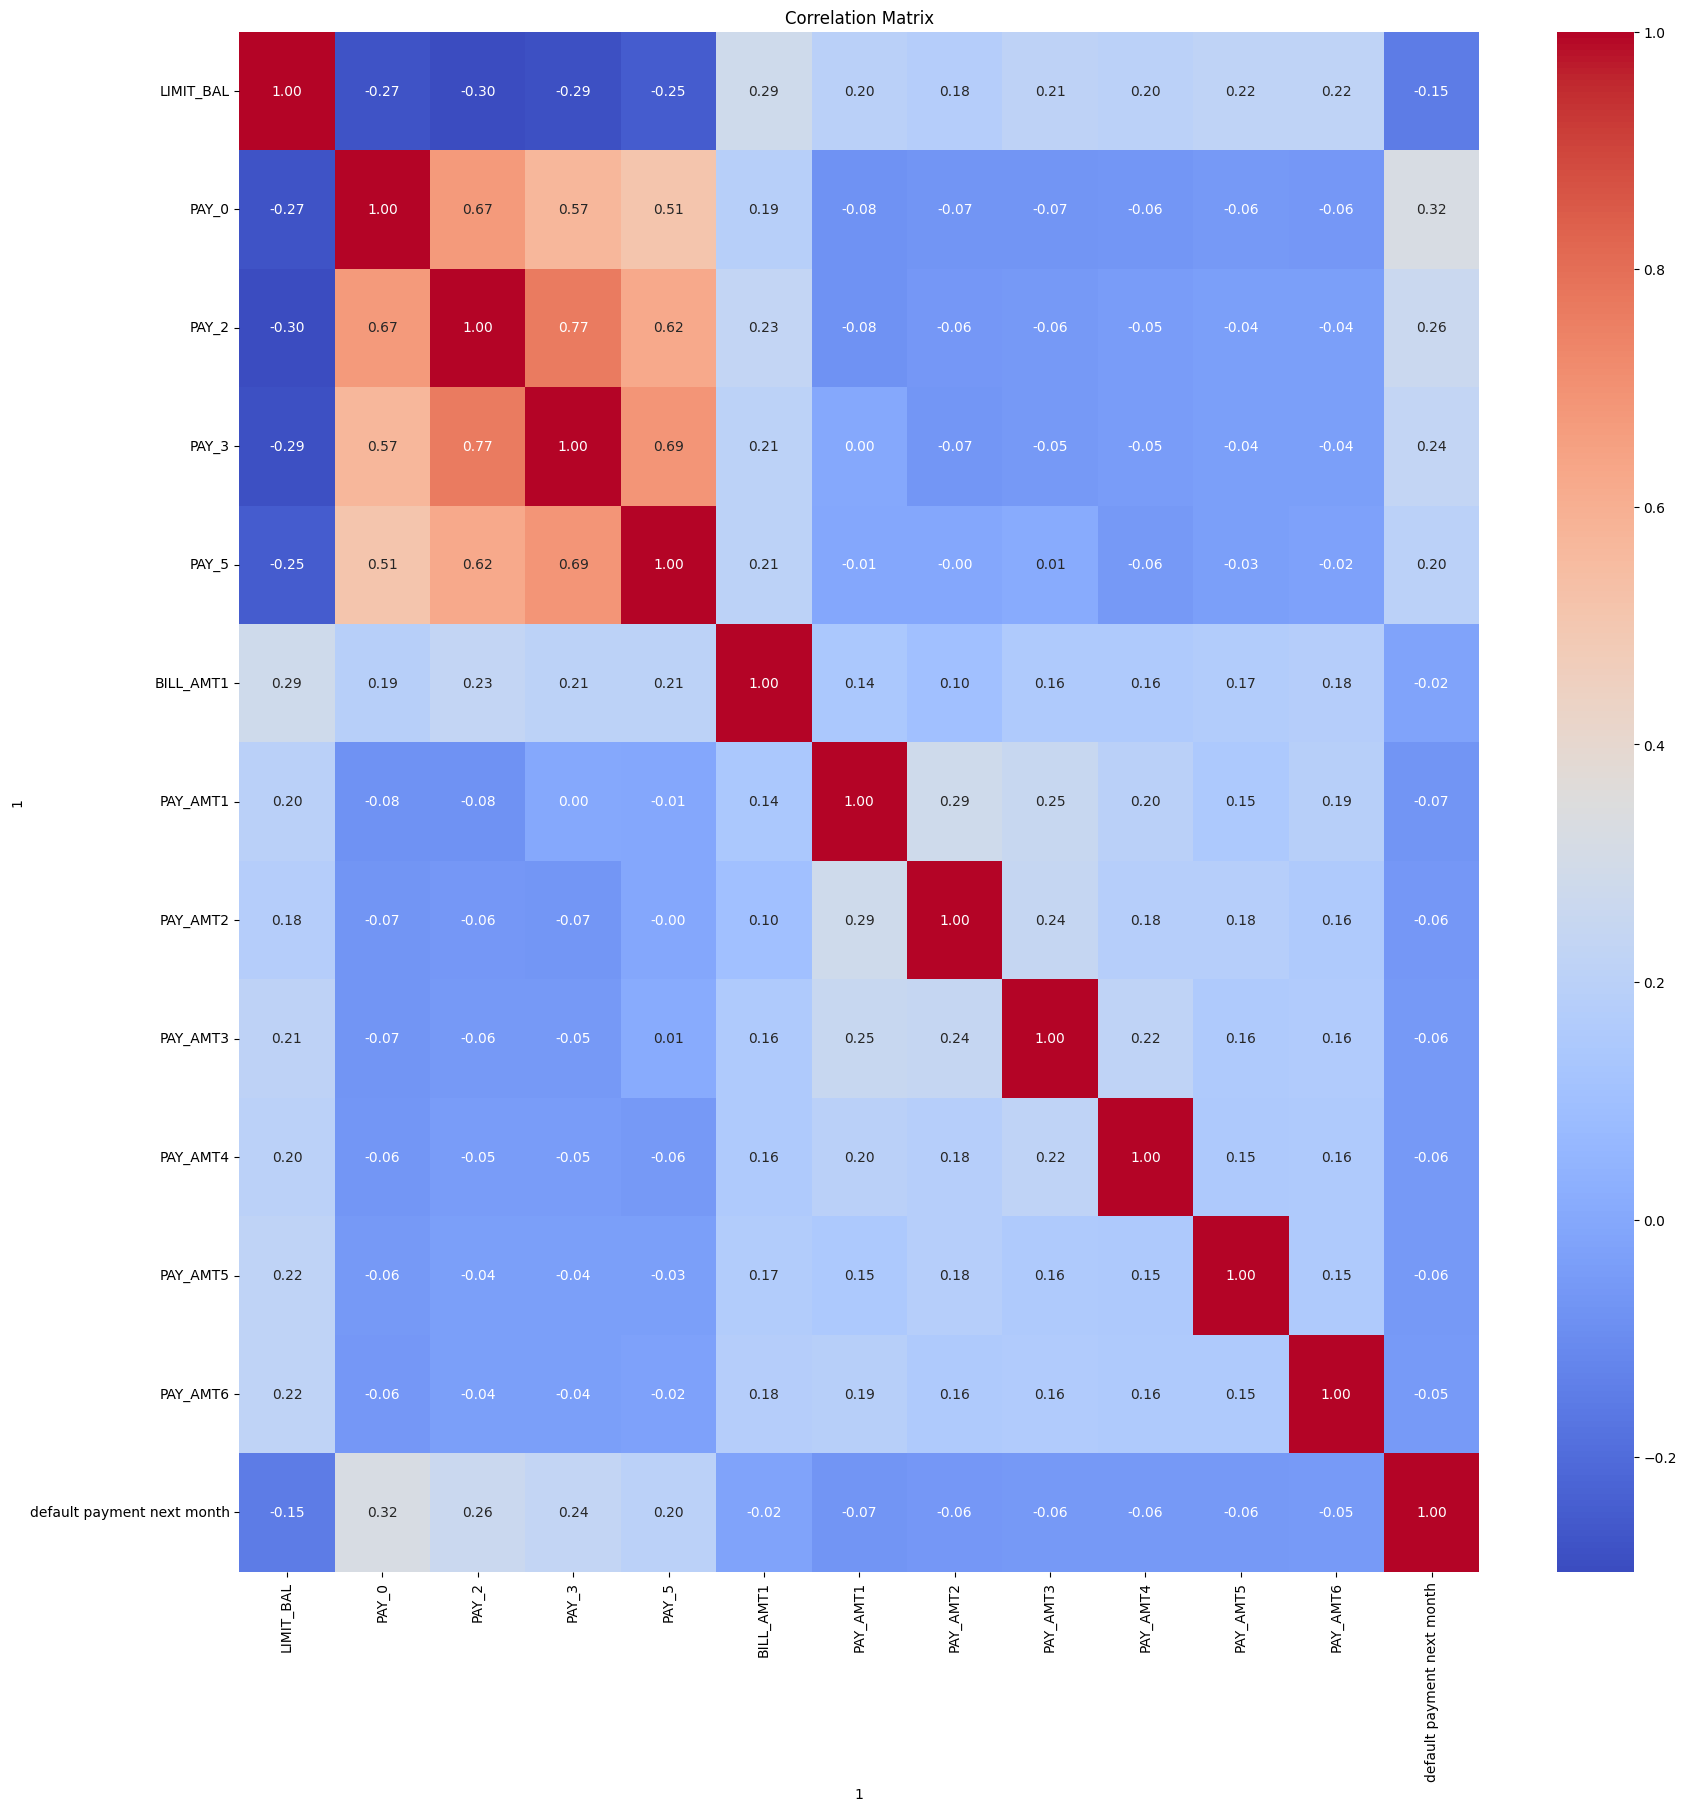

                     precision       recall          f1-score        support        
Negative Class       0.83            0.63            0.72            4666.0         
Positive Class       0.30            0.54            0.38            1334.0         
with_filter_method 0.6141666666666666


,method,result
0,with_filter_method,0.614167


In [11]:
filter_mstr = Master(with_smote=True)
filter_mstr.run_with_filter()
filter_mstr.organize_results()

In [12]:
pca_mstr = Master(with_smote=True)
pca_mstr.run_with_pca()
pca_mstr.organize_results()

                     precision       recall          f1-score        support        
Negative Class       0.87            0.74            0.80            4666.0         
Positive Class       0.40            0.61            0.48            1334.0         
with_pca 0.7103333333333334


,method,result
0,with_pca,0.710333


In [13]:
pca_mstr = Master(with_smote=True, algo="rf")
pca_mstr.run_with_pca()
pca_mstr.organize_results()

                     precision       recall          f1-score        support        
Negative Class       0.84            0.77            0.80            4666.0         
Positive Class       0.38            0.50            0.44            1334.0         
with_pca 0.7101666666666666


,method,result
0,with_pca,0.710167


In [14]:
pca_mstr = Master(with_smote=True, algo="svm")
pca_mstr.run_with_pca()
pca_mstr.organize_results()

                     precision       recall          f1-score        support        
Negative Class       0.86            0.85            0.85            4666.0         
Positive Class       0.49            0.51            0.50            1334.0         
with_pca 0.7746666666666666


,method,result
0,with_pca,0.774667


In [15]:
pca_mstr = Master(with_smote=True, algo="logreg")
pca_mstr.run_with_pca()
pca_mstr.organize_results()

                     precision       recall          f1-score        support        
Negative Class       0.86            0.64            0.73            4666.0         
Positive Class       0.33            0.64            0.44            1334.0         
with_pca 0.6365


,method,result
0,with_pca,0.6365


In [19]:
pca_mstr = Master(with_smote=True, algo="nn")
pca_mstr.run_with_cv()
pca_mstr.organize_results()

Epoch 2/20


/Users/mirbilal/Desktop/ASSGNS_MLL/assgn_3/assgn_3_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


785/785 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6975 - loss: 185.6427 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6984 - loss: 226.7336 - val_accuracy: 1.0000 - val_loss: 4.8122e-26
Epoch 4/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6967 - loss: 116.5419 - val_accuracy: 1.0000 - val_loss: 1.0979e-22
Epoch 5/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6964 - loss: 131.1132 - val_accuracy: 0.9996 - val_loss: 7.2502e-04
Epoch 6/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6938 - loss: 76.2084 - val_accuracy: 1.0000 - val_loss: 5.6169e-08
Epoch 7/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6920 - loss: 68.8895 - val_accuracy: 0.9979 - val_loss: 0.0541
Epoch 8/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6869 - loss: 43.5222 - val_accuracy: 0.9993 - val_loss: 0.0237
Epoch 9/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6902 - loss: 35.15

,method,result
0,run with cv,0.303


In [17]:
pca_mstr = Master(with_smote=True, algo="nn")
pca_mstr.run_with_pca()
pca_mstr.organize_results()

Epoch 2/20


/Users/mirbilal/Desktop/ASSGNS_MLL/assgn_3/assgn_3_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


785/785 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7967 - loss: 0.5161 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 3/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7104 - loss: 0.8849 - val_accuracy: 1.0000 - val_loss: 0.0060
Epoch 4/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6923 - loss: 0.8334 - val_accuracy: 1.0000 - val_loss: 0.0167
Epoch 5/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6709 - loss: 0.7660 - val_accuracy: 1.0000 - val_loss: 0.0132
Epoch 6/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6672 - loss: 0.7862 - val_accuracy: 1.0000 - val_loss: 0.0234
Epoch 7/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6559 - loss: 0.7571 - val_accuracy: 1.0000 - val_loss: 0.0153
Epoch 8/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6548 - loss: 0.7809 - val_accuracy: 1.0000 - val_loss: 0.0196
Epoch 9/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6533 - loss: 0.7748 - val_accuracy: 1.0000 - val_

,method,result
0,with_pca,0.78
